In [199]:
#standard ds libraries
import pandas as pd
import numpy as np

# vizualization
import matplotlib.pyplot as plt
import seaborn as sns

# stats testing 
from scipy import stats

#import SQL path
import env 
import os

# defined funtions  
import acquire
import prepare

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split # was in my prepare.py 
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix

In [62]:
def prep_telco(df):
    df = df.drop(columns=['internet_service_type_id', 'contract_type_id', 'payment_type_id'])
    df['internet_service_type'] = df['internet_service_type'].fillna('No internet service')

    df['gender_encoded'] = df.gender.map({'Female': 1, 'Male': 0})
    df['partner_encoded'] = df.partner.map({'Yes': 1, 'No': 0})
    df['dependents_encoded'] = df.dependents.map({'Yes': 1, 'No': 0})
    df['phone_service_encoded'] = df.phone_service.map({'Yes': 1, 'No': 0})
    df['paperless_billing_encoded'] = df.paperless_billing.map({'Yes': 1, 'No': 0})
    df['churn_encoded'] = df.churn.map({'Yes': 1, 'No': 0})
    
    dummy_df = pd.get_dummies(df[['multiple_lines',
                                     'online_security',
                                     'online_backup',
                                     'device_protection', 
                                     'tech_support',
                                     'streaming_tv',
                                     'streaming_movies', 
                                     'contract_type', 
                                     'internet_service_type',
                                     'payment_type']],
                                  drop_first=True).astype(int)
    
    df = pd.concat( [df, dummy_df], axis=1 )
    
    df.total_charges = df.total_charges.str.replace(' ', '0').astype(float)
    
    return df

In [63]:
from acquire import get_telco_data
df = get_telco_data()
df = prep_telco(df)
df.head().T

0               1  \
customer_id                                  0002-ORFBO      0003-MKNFE   
gender                                           Female            Male   
senior_citizen                                        0               0   
partner                                             Yes              No   
dependents                                          Yes              No   
tenure                                                9               9   
phone_service                                       Yes             Yes   
multiple_lines                                       No             Yes   
online_security                                      No              No   
online_backup                                       Yes              No   
device_protection                                    No              No   
tech_support                                        Yes              No   
streaming_tv                                        Yes              No   
streaming_movies                                     No             Yes   
paperless_billing                                   Yes              No   
monthly_charges                                    65.6            59.9   
total_charges                                     593.3           542.4   
churn                                                No              No   
contract_type                                  One year  Month-to-month   
internet_service_type                               DSL             DSL   
payment_type                               Mailed check    Mailed check   
gender_encoded                                        1               0   
partner_encoded                                       1               0   
dependents_encoded                                    1               0   
phone_service_encoded                                 1               1   
paperless_billing_encoded                             1               0   
churn_encoded                                         0               0   
multiple_lines_No phone service                       0               0   
multiple_lines_Yes                                    0               1   
online_security_No internet service                   0               0   
online_security_Yes                                   0               0   
online_backup_No internet service                     0               0   
online_backup_Yes                                     1               0   
device_protection_No internet service                 0               0   
device_protection_Yes                                 0               0   
tech_support_No internet service                      0               0   
tech_support_Yes                                      1               0   
streaming_tv_No internet service                      0               0   
streaming_tv_Yes                                      1               0   
streaming_movies_No internet service                  0               0   
streaming_movies_Yes                                  0               1   
contract_type_One year                                1               0   
contract_type_Two year                                0               0   
internet_service_type_Fiber optic                     0               0   
internet_service_type_No internet service             0               0   
payment_type_Credit card (automatic)                  0               0   
payment_type_Electronic check                         0               0   
payment_type_Mailed check                             1               1   

                                                          2                 3  \
customer_id                                      0004-TLHLJ        0011-IGKFF   
gender                                                 Male              Male   
senior_citizen                                            0                 1   
partner                                               

In [22]:
from prepare import split_telco_data
train, validate, test = split_telco_data(df)

print(f'Train Telco data ->{train.shape}')
print(f'Validate Telco data ->{validate.shape}')
print(f'Test.Telco data ->{test.shape}')

Train Telco data ->(3943, 48)
Validate Telco data ->(1691, 48)
Test.Telco data ->(1409, 48)


### inital questions 
- What featues may lead to the rate of churn? 
- Do monthy charges impact churn? 
- Does being a senior citizen impact who churned? If it does, do I need to change my strategy of imputation? (in other words, do those assumptions have big impact)
- Are customers with DSL more or less likely to churn?
- What month are customers most likely to churn and does that depend on their contract type?
- Is there a service that is associated with more churn than expected?
- Do customers who churn have a higher average monthly spend than those who don't?



In [26]:
sns.pairplot(train, hue='churn', height=3)

Interactions of 2 Variables

For bivariate exploration, we should analyze each feature with respect to the target variable and document takeaways.

A scatterplot will help us visualize numeric to numeric columns.

A catplot, barplot, or boxplot will help us visualize categorical variables with numeric variables. A nice thing about a .barplot is that by setting the binary target to the y axis, we see proportions.

Always write down what questions you have before you explore.

Always document your findings and takeaways, even if the takeaway is "There's nothing here between x and y"

Some findings from bi-variate exploration may need more detailed investigation with an additional variable.

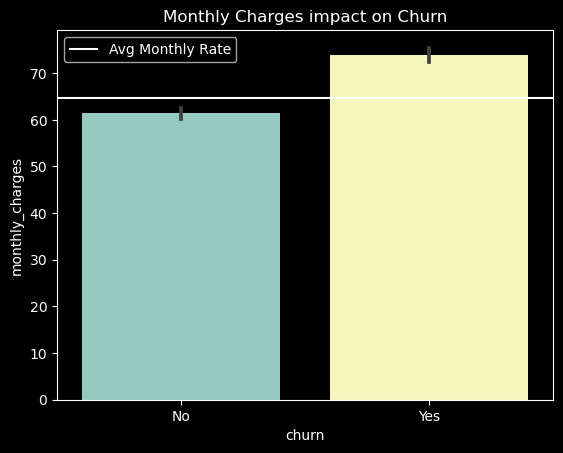

In [127]:
# Do monthly charges impact churn? 

sns.barplot(x='churn', y='monthly_charges', data=train)

avg_monthly_rate = train.monthly_charges.mean()
plt.axhline(avg_monthly_rate, label='Avg Monthly Rate')
plt.legend(loc='upper left')

plt.title('Monthly Charges impact on Churn')
plt.show()

- looking at this graph it seems that monthly charges do not have a significant impact on churn ^

In [128]:
# Let's run a chi squared to compare proportions, to have more confidence
alpha = 0.05
null_hypothesis = "monthly charges and churn of ticket are independent"
alternative_hypothesis = "there is a relationship between churn and monthly charges"

# Setup a crosstab of observed survival to pclass
observed = pd.crosstab(train.churn, train.monthly_charges)
observed

monthly_charges  18.25   18.40   18.70   18.80   18.85   18.90   18.95   \
churn                                                                     
No                    1       1       2       4       3       1       2   
Yes                   0       0       0       0       0       0       0   

monthly_charges  19.00   19.05   19.10   ...  116.55  116.60  116.80  117.15  \
churn                                    ...                                   
No                    3       9       6  ...       1       1       1       1   
Yes                   0       0       1  ...       0       0       0       0   

monthly_charges  117.45  117.60  118.35  118.60  118.65  118.75  
churn                                                            
No                    0       1       0       2       1       1  
Yes                   1       0       1       0       0       0  

[2 rows x 1341 columns]

In [129]:

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")
p

Reject the null hypothesis that monthly charges and churn of ticket are independent
Sufficient evidence to move forward understanding that there is a relationship between churn and monthly charges


2.0741791404838627e-08

- There does seem to be a ralationship between monthly charges and churn ^ 

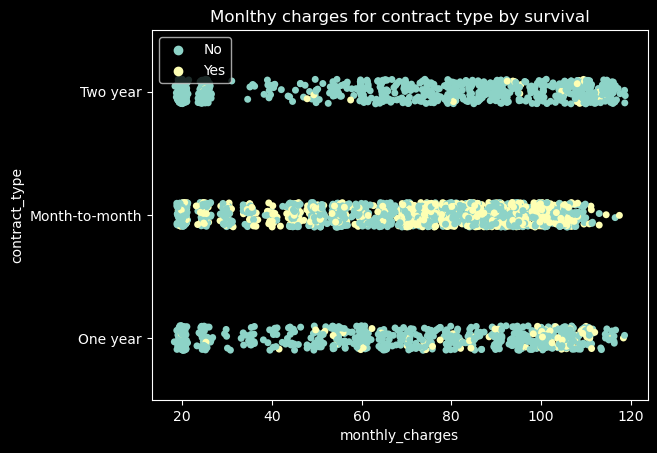

In [124]:
 # does this change based on contract type? 
 
 sns.stripplot(
    data=train,
    y='contract_type',
x='monthly_charges',
hue='churn')
plt.title('Monlthy charges for contract type by survival')
plt.legend(loc='upper left')
plt.show()

# wanted to see of there is any significat difference in monthy price between the contract types 

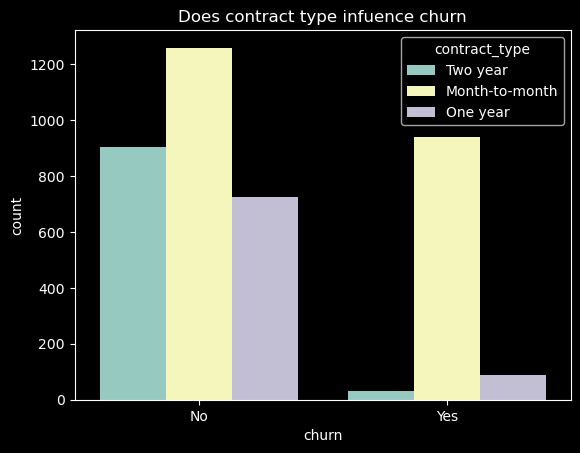

In [126]:
# does contract type infuance churn 

sns.countplot(data = train, x= 'churn', hue = 'contract_type')
plt.title('Does contract type infuence churn')
plt.show()

- customers with month to month contracts churn the most out of all contract types ^ 

In [130]:
# Let's run a chi squared to compare proportions, to have more confidence
alpha = 0.05
null_hypothesis = "contract type and churn of ticket are independent"
alternative_hypothesis = "there is a relationship between churn and contract type"

# Setup a crosstab of observed survival to pclass
observed = pd.crosstab(train.churn, train.contract_type)
observed


contract_type  Month-to-month  One year  Two year
churn                                            
No                       1258       726       903
Yes                       939        87        30

In [131]:

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")
p

Reject the null hypothesis that contract type and churn of ticket are independent
Sufficient evidence to move forward understanding that there is a relationship between churn and contract type


2.400667548360687e-143

- confirmed relationship between contract type and churn 

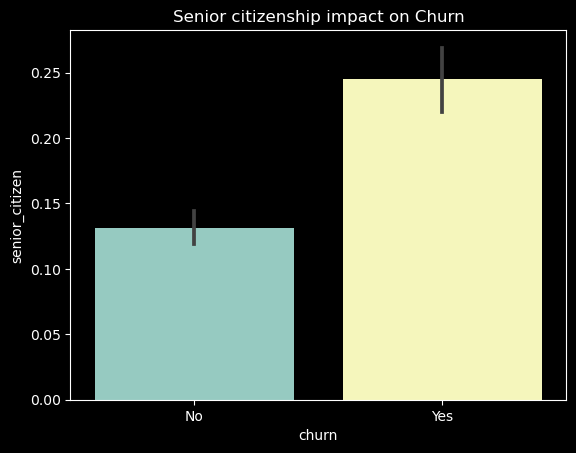

In [54]:
# Does being a senior citizen impact churn? 

sns.barplot(x='churn', y='senior_citizen', data=train)

plt.title('Senior citizenship impact on Churn')
plt.show()

In [58]:
# Categorical vs Categorical so a chi squared test 

alpha = 0.05
null_hypothesis = "senior citizenship and churn are independent"
alternative_hypothesis = "there is a relationship between senior citizenship and churn"

# Setup a crosstab of observed survival to pclass
observed = pd.crosstab(train.churn, train.senior_citizen)
observed


senior_citizen     0    1
churn                    
No              2509  378
Yes              797  259

In [59]:
chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")
p

Reject the null hypothesis that senior citizenship and churn are independent
Sufficient evidence to move forward understanding that there is a relationship between senior citizenship and churn


8.75077221120432e-18

- confirmed that there is a relationship between senior citizenship and churn 

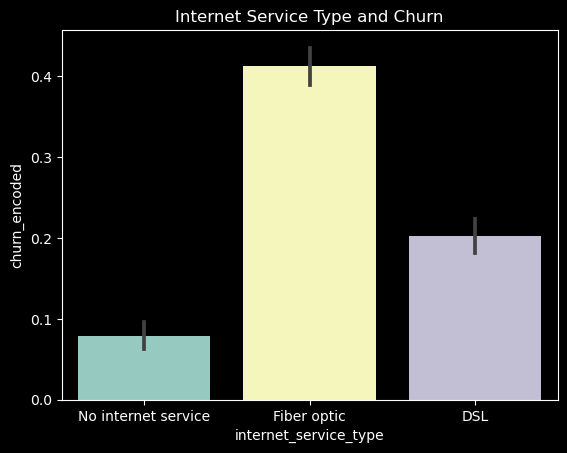

In [71]:
# Are costomers with DSL more or less likly to churn? 

sns.barplot(x='internet_service_type', y='churn_encoded', data=train)
plt.title('Internet Service Type and Churn')
plt.show()


In [116]:
print(f"Overall churn rate:", round(train.churn_encoded.mean(), 2))
print(f"Overall DSL churn rate", round(train[train.internet_service_type == 'DSL'].churn_encoded.mean(), 2))
print(f"Overall Fiber Optic churn rate", round(train[train.internet_service_type == 'Fiber optic'].churn_encoded.mean(), 2))
print(f"Overall No internet service churn rate", round(train[train.internet_service_type == 'No internet service'].churn_encoded.mean(), 2))


Overall churn rate: 0.27
Overall DSL churn rate 0.2
Overall Fiber Optic churn rate 0.41
Overall No internet service churn rate 0.08


In [132]:
# not sure how to isolate one 

# categorial vs categorical so we use chi squared test

alpha = 0.05
null_hypothesis = "customers with DSL and churn are independent"
alternative_hypothesis = "there is a relationship between customers with DSL and churn"

# Setup a crosstab of observed survival to pclass
observed = pd.crosstab(train.churn, train.internet_service_type == 'DSL')
observed

internet_service_type  False  True 
churn                              
No                      1805   1082
Yes                      782    274

In [133]:
chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")
p

Reject the null hypothesis that customers with DSL and churn are independent
Sufficient evidence to move forward understanding that there is a relationship between customers with DSL and churn


1.9141181653098816e-11

- their does seem to be a ralationship however customers with DSL are less likly to leave than customers with fiber optic

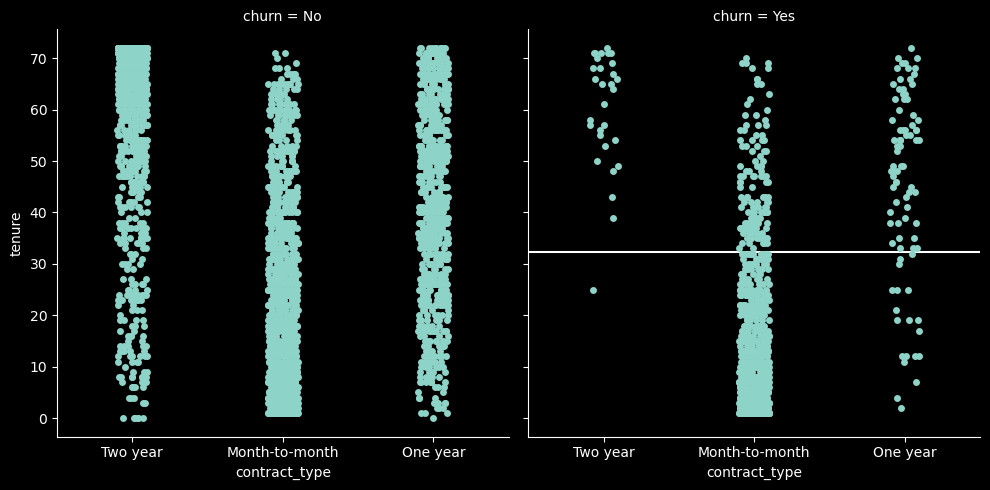

In [100]:
# what month are customers likely to churn and does that depend on their contract type? 

# tenure, contract type, churn 

sns.catplot(x='contract_type', y='tenure', col='churn', data=train)
avg_tenure = train.tenure.mean()
plt.axhline(avg_tenure, label='Avg Tenure')
# plt.legend(loc='upper right')
plt.show()

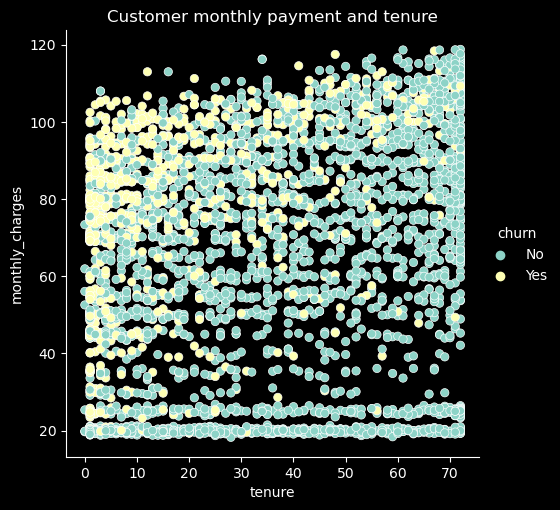

In [205]:
sns.relplot(data=train, x='tenure', y='monthly_charges', hue='churn')
plt.title('Customer monthly payment and tenure')
plt.show()

In [207]:
print(f"Overall churn rate:", round(train.churn_encoded.mean(), 2))
print(f"25 or less month tenure churn rate", round(train[train.tenure <= 25].churn_encoded.mean(), 2))
print(f"50 or less month churn rate", round(train[train.tenure <= 50].churn_encoded.mean(), 2))
print(f"100 or less month churn rate", round(train[train.tenure <= 100].churn_encoded.mean(), 2))

Overall churn rate: 0.27
25 or less month tenure churn rate 0.42
50 or less month churn rate 0.35
100 or less month churn rate 0.27


- most people tend to churn within the first 25 months
- is there a better way to narrow this down? 

In [ ]:
# not sure what they mean by what month? 

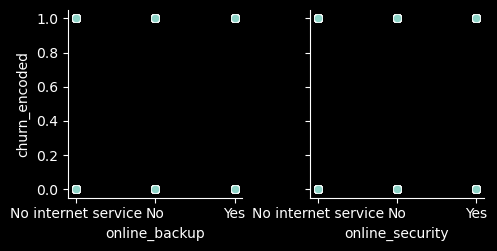

In [211]:
sns.pairplot(train, x_vars=['online_backup', 'online_security'], y_vars=['churn_encoded'])

<Axes: xlabel='streaming_movies', ylabel='churn_encoded'>

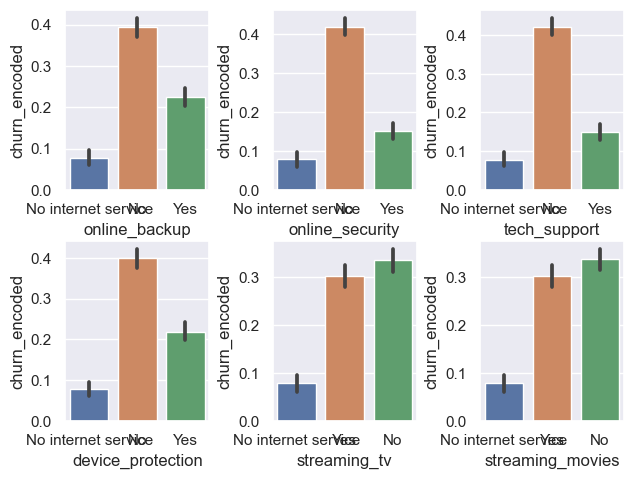

In [229]:
#set seaborn plotting aesthetics as default
sns.set()

#define plotting region (2 rows, 2 columns)
fig, axes = plt.subplots(nrows=2, ncols=3)
fig.tight_layout()


#create boxplot in each subplot
sns.barplot(data=train, y='churn_encoded', x='online_backup', ax=axes[0,0])
sns.barplot(data=train, y='churn_encoded', x='online_security', ax=axes[0,1])
sns.barplot(data=train, y='churn_encoded', x='tech_support', ax=axes[0,2])
sns.barplot(data=train, y='churn_encoded', x='device_protection', ax=axes[1,0])
sns.barplot(data=train, y='churn_encoded', x='streaming_tv', ax=axes[1,1])
sns.barplot(data=train, y='churn_encoded', x='streaming_movies', ax=axes[1,2])

<Axes: xlabel='payment_type', ylabel='churn_encoded'>

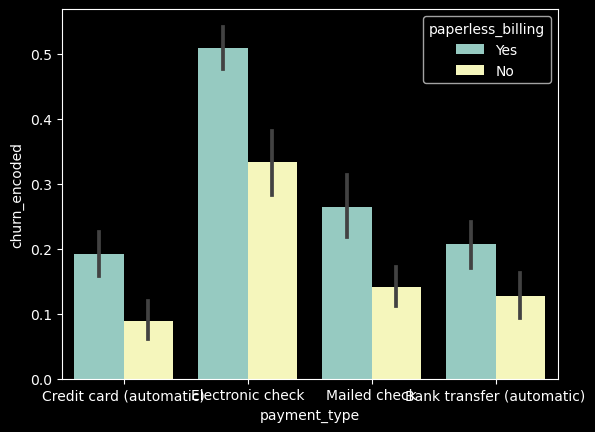

In [184]:
sns.barplot(y='churn_encoded', x='payment_type', data=train, hue='paperless_billing')

<Axes: xlabel='multiple_lines', ylabel='phone_service_encoded'>

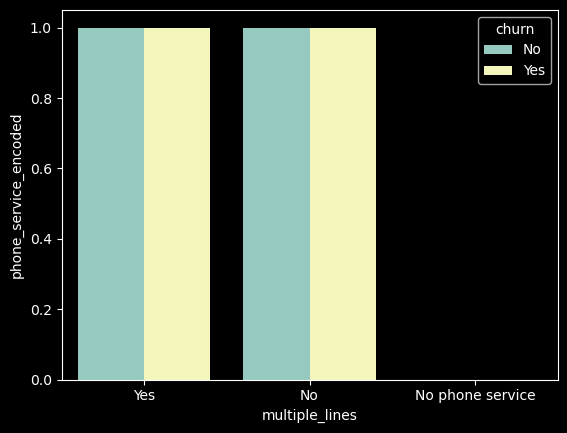

In [192]:
sns.barplot(y='phone_service_encoded', x='multiple_lines', data=train, hue='churn')

In [190]:
train.phone_service.value_counts(), train.multiple_lines.value_counts()

(phone_service
 Yes    3555
 No      388
 Name: count, dtype: int64,
 multiple_lines
 No                  1872
 Yes                 1683
 No phone service     388
 Name: count, dtype: int64)

# this definately suprized me ^

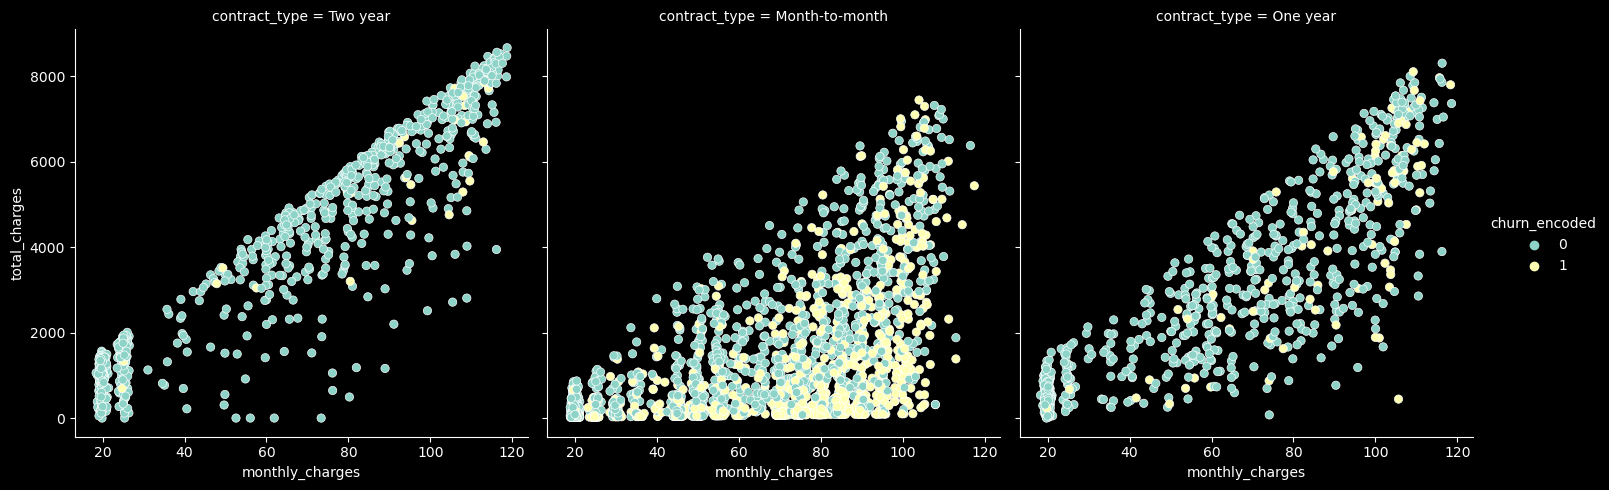

In [202]:
sns.relplot(x='monthly_charges', y='total_charges', data=train, hue='churn_encoded', col='contract_type')

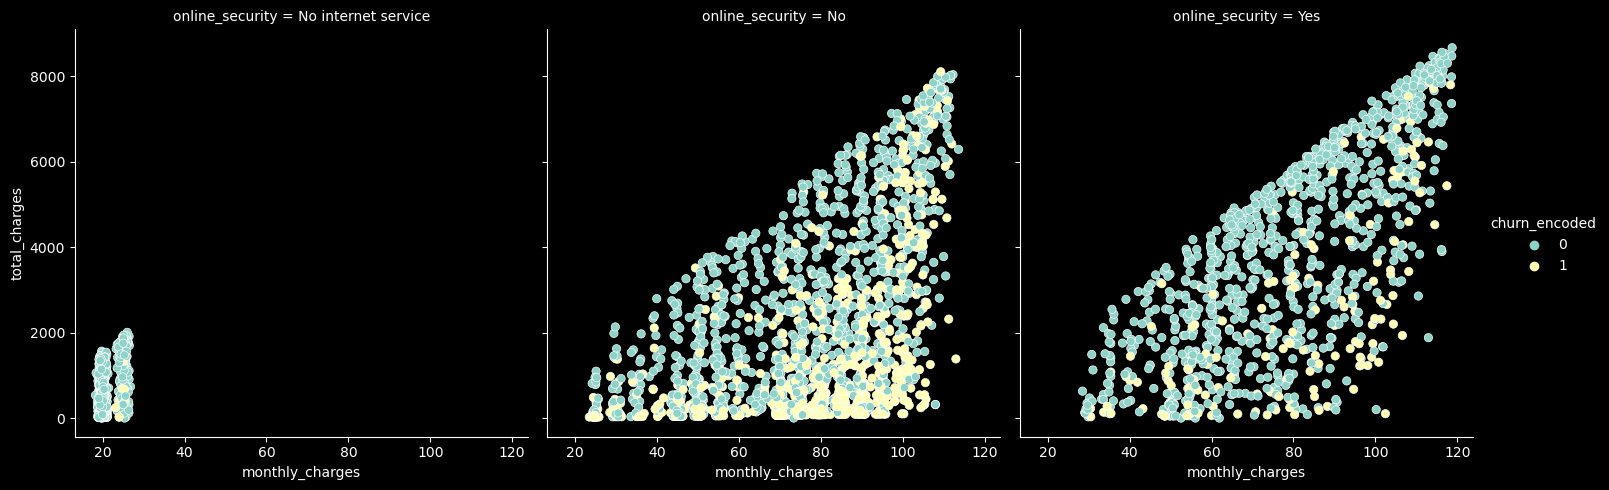

In [203]:
sns.relplot(x='monthly_charges', y='total_charges', data=train, hue='churn_encoded', col='online_security')

In [ ]:
# is there a service that is accodiated with more churn than expected? 

In [ ]:
# Do customers who churn have a higher than avg monlthy bill than those who do not?  

# feature that I am moving on with to modeling:
- Contract type (found that customers with month to month contract types are most likely to leave)
- Monthy Charges
- Total Charges 
- Senior citizen 

In [236]:
# baseline
baseline_prediction = train.churn_encoded.mode()

baseline_accuracy = (train.churn_encoded == 0).mean()

print(f'Baseline prediction -> {baseline_prediction}')

print(f'Baseline accuracy -> { baseline_accuracy}')

Baseline prediction -> 0    0
Name: churn_encoded, dtype: int64
Baseline accuracy -> 0.7321836165356328


# baseline to beat ^ 

In [260]:
lables = sorted(y_train.unique())
lables
y_train.unique()

array([0, 1])

In [269]:
def get_metrics(model,xtrain,ytrain,xtest,ytest) -> str:
    
    labels = sorted(y_train.unique()) # orders the array of the target variable 

    # OUTPUTS AN ARRAY OF PREDICTIONS
    preds = model.predict(xtest)
    print("Accuracy Score:", model.score(xtest,ytest))
    print()
    print('Confusion Matrix:')
    conf = confusion_matrix(ytest,preds)
    TP = conf[0, 0]
    TN = conf[1, 1]
    FP = conf[0, 1]
    FN = conf[1, 0]
    conf = pd.DataFrame(conf,
            index=[str(label) + '_actual'for label in labels],
            columns=[str(label) + '_predict'for label in labels])
    print(conf)
    print('')
    print(f'True Positive -> {TP}')
    print(f'True Negative -> {TN}')
    print(f'False Positive -> {FP}')
    print(f'False Negative -> {FN}')
    print()
    print("Classification Report:")
    print(classification_report(ytest, preds))

In [237]:
telco_drop = ['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents', 'tenure', 'phone_service', 'multiple_lines', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'paperless_billing', 'monthly_charges',
       'total_charges', 'churn', 'churn_encoded', 'contract_type', 'internet_service_type', 'payment_type']

telco_keep = ['gender_encoded', 'partner_encoded', 'dependents_encoded', 'phone_service_encoded',
       'paperless_billing_encoded', 'multiple_lines_No phone service', 'multiple_lines_Yes',
       'online_security_No internet service', 'online_security_Yes', 'online_backup_No internet service', 'online_backup_Yes',
       'device_protection_No internet service', 'device_protection_Yes', 'tech_support_No internet service', 'tech_support_Yes',
       'streaming_tv_No internet service', 'streaming_tv_Yes', 'streaming_movies_No internet service', 'streaming_movies_Yes', 
       'contract_type_One year', 'contract_type_Two year', 'internet_service_type_Fiber optic', 'internet_service_type_No internet service',
       'payment_type_Credit card (automatic)', 'payment_type_Electronic check', 'payment_type_Mailed check']

In [238]:
# SPLIT DATA INTO X AND Y DATA SETS
# this will allow us to separate the target variable and the features 

X_train = train.drop(columns=telco_drop) # all the features, will NOT contain the target variable 

X_validate = validate.drop(columns=telco_drop) # same as above 

X_test = test.drop(columns=telco_drop) # same as above 

y_train = train.churn_encoded # will only contain the target variable 

y_validate = validate.churn_encoded # same as above 

y_test = test.churn_encoded # same as above 

In [239]:
# for classification you can change the algorithm to gini or entropy (information gain).  
# Default is gini.

clf = DecisionTreeClassifier(max_depth=3, random_state=123)
clf


DecisionTreeClassifier(max_depth=3, random_state=123)

In [241]:
# model.fit(X, y)

clf = clf.fit(X_train, y_train)


In [270]:
get_metrics(clf,X_train,y_train,X_test,y_test)

Accuracy Score: 0.7700496806245565

Confusion Matrix:
          0_predict  1_predict
0_actual        886        149
1_actual        175        199

True Positive -> 886
True Negative -> 199
False Positive -> 149
False Negative -> 175

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1035
           1       0.57      0.53      0.55       374

    accuracy                           0.77      1409
   macro avg       0.70      0.69      0.70      1409
weighted avg       0.77      0.77      0.77      1409



In [271]:
def compute_metrics(TN,FP,FN,TP):
    all_ = (TP + TN + FP + FN)

    accuracy = (TP + TN) / all_

    TPR = recall = TP / (TP + FN)
    FPR = FP / (FP + TN)

    TNR = TN / (FP + TN)
    FNR = FN / (FN + TP)

    precision =  TP / (TP + FP)
    f1 =  2 * ((precision * recall) / ( precision + recall))

    support_pos = TP + FN
    support_neg = FP + TN

    print(f"Accuracy: {accuracy}\n")
    print(f"True Positive Rate/Sensitivity/Recall/Power: {TPR}")
    print(f"False Positive Rate/False Alarm Ratio/Fall-out: {FPR}")
    print(f"True Negative Rate/Specificity/Selectivity: {TNR}")
    print(f"False Negative Rate/Miss Rate: {FNR}\n")
    print(f"Precision/PPV: {precision}")
    print(f"F1 Score: {f1}\n")
    print(f"Support (0): {support_pos}")
    print(f"Support (1): {support_neg}")

In [273]:
TP = 886
TN = 199
FP = 149
FN = 175

In [274]:
compute_metrics(TN, FP, FN, TP)

Accuracy: 0.7700496806245565

True Positive Rate/Sensitivity/Recall/Power: 0.8350612629594723
False Positive Rate/False Alarm Ratio/Fall-out: 0.4281609195402299
True Negative Rate/Specificity/Selectivity: 0.5718390804597702
False Negative Rate/Miss Rate: 0.1649387370405278

Precision/PPV: 0.8560386473429952
F1 Score: 0.8454198473282443

Support (0): 1061
Support (1): 348


In [157]:
#for many
for x in range(1,20):
#     print(x)
    clf = DecisionTreeClassifier(max_depth=x, random_state=7)
    clf.fit(X_train, y_train)
    acc = clf.score(X_train, y_train)
    print(f'for depth of {x:2}, the accuracy is {round(acc,2)}')

for depth of  1, the accuracy is 0.73
for depth of  2, the accuracy is 0.73
for depth of  3, the accuracy is 0.75
for depth of  4, the accuracy is 0.77
for depth of  5, the accuracy is 0.77
for depth of  6, the accuracy is 0.78
for depth of  7, the accuracy is 0.79
for depth of  8, the accuracy is 0.8
for depth of  9, the accuracy is 0.82
for depth of 10, the accuracy is 0.83
for depth of 11, the accuracy is 0.86
for depth of 12, the accuracy is 0.87
for depth of 13, the accuracy is 0.89
for depth of 14, the accuracy is 0.91
for depth of 15, the accuracy is 0.91
for depth of 16, the accuracy is 0.92
for depth of 17, the accuracy is 0.92
for depth of 18, the accuracy is 0.92
for depth of 19, the accuracy is 0.92


TypeError: can only concatenate str (not "numpy.int64") to str

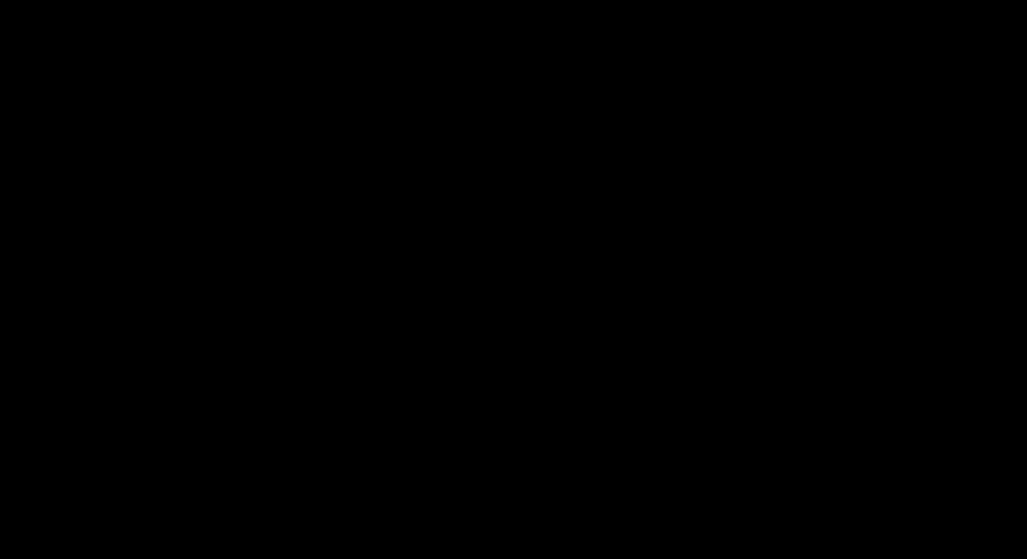

In [150]:
plt.figure(figsize=(13, 7))
plot_tree(clf, feature_names=X_train.columns, class_names=clf.classes_, rounded=True)


In [ ]:
precision_score(paws_df['actual'], paws_df['model1'], pos_label='dog')
recall_score(paws_df['actual'], paws_df['model1'], pos_label='dog')
accuracy_score(paws_df['actual'], paws_df['model1'])
